In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances                 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from scipy.sparse import csr_matrix 

import pandas as pd
import numpy as np
import sys      
import os
%matplotlib inline

# Understanding initialization impact on convergence

In [26]:
random_state = np.random.RandomState(0)

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 10

# Number of time the k-means algorithm will be run with different
# centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size ** 2

def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j]
                        for i in range(grid_size)
                        for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1]))

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center
                        for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)



Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init


Text(0.5,1,'Mean inertia for various k-means init across 5 runs')

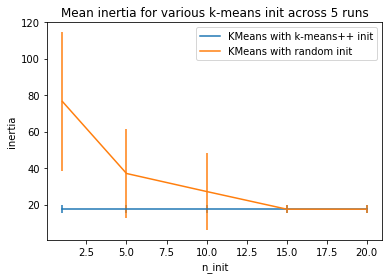

In [25]:
# Part 1: Quantitative evaluation of various init methods

plt.figure()
plots = []
legends = []

cases = [
    (KMeans, 'k-means++', {}),
    (KMeans, 'random', {}),
]

for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(n_clusters=n_clusters, init=init, random_state=run_id,
                         n_init=n_init, **params).fit(X)
            inertia[i, run_id] = km.inertia_
    p = plt.errorbar(n_init_range, inertia.mean(axis=1), inertia.std(axis=1))
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel('n_init')
plt.ylabel('inertia')
plt.legend(plots, legends)
plt.title("Mean inertia for various k-means init across %d runs" % n_runs)



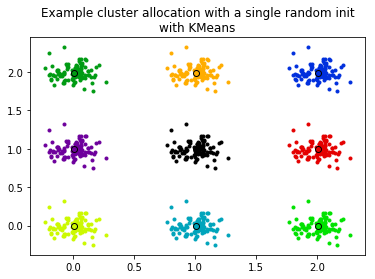

In [32]:
# Part 2: Qualitative visual inspection of the convergence

X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1,
                     random_state=random_state).fit(X)

plt.figure()
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], 'o', marker='.', c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o',
             markerfacecolor=color, markeredgecolor='k', markersize=6)
    plt.title("Example cluster allocation with a single random init\n"
              "with KMeans")

plt.show()

# Use k-means to cluster wikipedia articles

In [82]:
# import text documents from wikipedia abstracts
wiki_data=pd.read_csv('new_zeland_people.tsv',delimiter='\t', index_col='name')['abstract']

wiki_data.head()

name
A. R. D. Fairburn       "Arthur Rex Dugard "Rex" Fairburn (2 February ...
Aaran Franklyn Lines    "Aaran Franklyn Lines (born 21 December 1976 i...
Aaran Lines             "Aaran Franklyn Lines (born 21 December 1976 i...
Aaron Gate              "Aaron Gate (born 26 November 1990) is a New Z...
Aaron Harper            "Aaron David Harper (born 20 May 1967) is an A...
Name: abstract, dtype: object

In [84]:
#Define the TFIDF vectorizer that will be used to process the data
tfidf_vectorizer = TfidfVectorizer()
#Apply this vectorizer to the full dataset to create normalized vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(wiki_data)

In [85]:
#normalize the tfidfmatrix
tf_idf = normalize(tfidf_matrix)

In [105]:
# compute kmeans using random initialization
kmeans = KMeans(n_clusters=100, init='random').fit(tf_idf) # init can be used with 'random' or the 'k-means++' 
# predict the closest cluster for each point
labels= kmeans.predict(tf_idf)

In [106]:
# retrieve other pages from a cluster
def get_cluster(cluster_nb, labels, dataset):
    curr_cluster=[]
    abstract=[]
    for index in range(len(labels)):
        if labels[index]==cluster_nb:
            curr_cluster.append(dataset.index.values[index,])
            abstract.append(dataset.iloc[index,])
            
    result = pd.DataFrame({'names': curr_cluster,
                           'abstract': abstract})
    return result
        

In [107]:
# Find the cluster in which Taika Waititi is
pos = wiki_data.index.get_loc("Taika Waititi")
labels[pos]

66

In [108]:
cluster= get_cluster(labels[pos], labels, wiki_data)
cluster

,names,abstract
0,Andrew Adamson,"""Andrew Ralph Adamson, MNZM (born 1 December 1..."
1,Andrew Niccol,"""Andrew M. Niccol (born 10 June 1964) is a New..."
2,Angela Bloomfield,"""Angela Bloomfield (born 11 December 1972) is ..."
3,Barbara Sumner-Burstyn,"""Barbara Sumner Burstyn is a film producer and..."
4,Bartholomew John,"""Bartholomew John (born 24 August 1952 in Chri..."
5,Bill Stalker,"""William Robert ""Bill"" Stalker (3 August 1948 ..."
6,Bridgette Allen,"""Bridgette Allen is a New Zealand born Jazz si..."
7,Bruce Allpress,"""Bruce Robert Allpress (born 25 August 1930) i..."
8,Bruce Hopkins,"""Raymond Bruce Hopkins (born 25 November 1955)..."
9,Bruce Spence,"""Bruce Spence (born 17 September 1945) is a Ne..."


## Choose the right number of k

In [39]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.title('K vs. Inertia')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [48]:
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100, 300]

In [49]:
for n_clusters in k_list:
    km = KMeans(n_clusters=n_clusters, init='k-means++').fit(tf_idf)
    heterogeneity_values.append(km.inertia_)


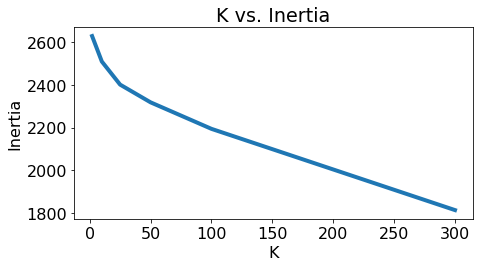

In [50]:
plot_k_vs_heterogeneity(k_list, heterogeneity_values)